<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python/blob/main/06_yandex_afisha_business_metrics/7_yandex_afisha_business_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort analysis and business metrics calculation: DAU, WAU, MAU; AOV; LTV; retention; CAC; ROMI. (Yandex_practicum_eng)

<b>Task:</b>
Identify profitable and unprofitable traffic sources for marketing budget reallocation for an online entertainment ticket service Yandex.Afisha.
<br>
<b>Data description: </b>
data from June 2017 to May 2018:
1. visits_log.csv - server log of visits to the Yandex.Afisha site,
- Uid — unique user identifier,
- Device — user device category,
- Start Ts — session start date and time,
- End Ts — session end date and time,
- Source Id — traffic source identifier.
2. orders_log.csv - orders
- Uid — unique user identifier,
- Buy Ts — date and time of the order,
- Revenue — a sum of orders.
3. costs.csv - advertising costs statistics.
- source_id — source identifier,
- dt — date of the advertising campaign,
- costs — costs of campaigns.

### Stage 1. Getting and processing data

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
visits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
costs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


#### Checking for duplicates, missing values and wrong data types

In [6]:
visits.shape

(359400, 5)

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits.duplicated().sum()

0

In [9]:
orders.shape

(50415, 3)

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
orders.duplicated().sum()

0

In [12]:
costs.shape

(2542, 3)

In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [14]:
costs.duplicated().sum()

0

<b>Results:</b><br>
   No missing values, no duplicates. Let's convert the date columns to datetime.

In [15]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

#### Standardizing column names

In [16]:
visits.columns = visits.columns.str.replace(' ', '_').str.lower()
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [17]:
orders.columns = orders.columns.str.replace(' ', '_').str.lower()
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

#### EDA

##### Visits  

In [18]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [19]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [20]:
visits[['start_ts','end_ts']].describe(datetime_is_numeric=True)

,start_ts,end_ts
count,359400,359400
mean,2017-12-18 06:17:32.010517760,2017-12-18 06:28:15.036205056
min,2017-06-01 00:01:00,2017-06-01 00:02:00
25%,2017-10-15 09:41:00,2017-10-15 09:45:45
50%,2017-12-18 18:46:00,2017-12-18 18:59:30
75%,2018-02-28 09:54:00,2018-02-28 10:08:15
max,2018-05-31 23:59:00,2018-06-01 01:26:00


There are only two categories of user devices and 9 sources of traffic with a wide range in popularity. Source 8 is not available, while sources 6 and 7 have very few visits. The period by session start date: from June 2017 to May 2018. However, the latest session end date is June 1, 2018.

Let's check whether the dates are correct. Session start date should be <= session end date.

In [21]:
visits[visits['start_ts'] > visits['end_ts']]

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


In [22]:
visits = visits[~(visits['start_ts'] > visits['end_ts'])]

Two wrong entries were found and removed.

##### Orders

In [23]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

The range is large, and the average is almost two times higher than the median. Let's look at the distribution.

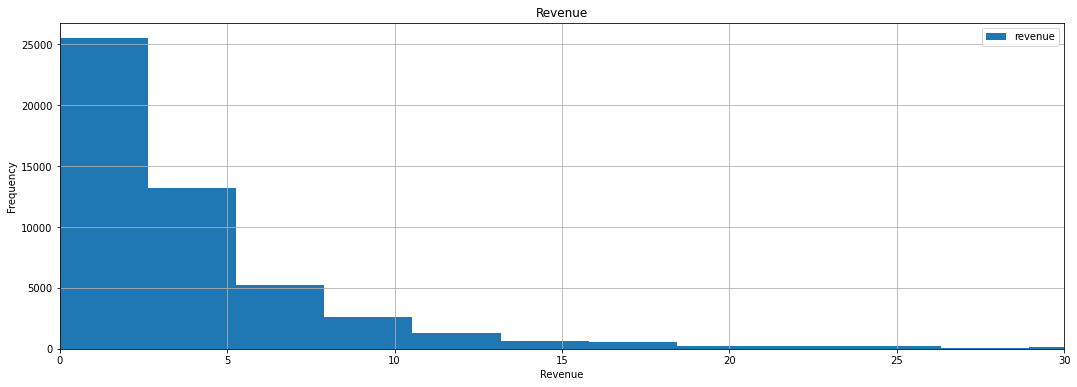

In [24]:
orders.plot(kind='hist', y='revenue', bins=1000, grid=True, figsize=(18,6), title='Revenue', xlim=(0,30))
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

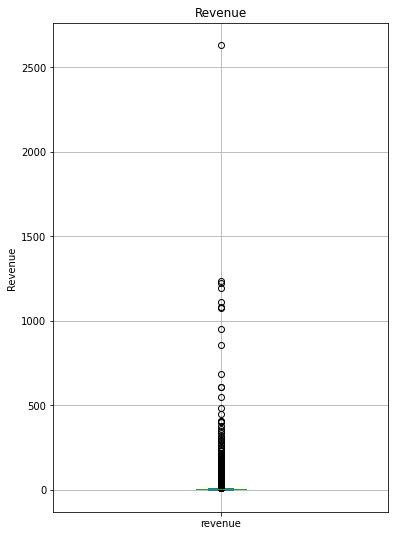

In [25]:
orders.plot(kind='box', y='revenue', grid=True, figsize=(6,9), title='Revenue')
plt.ylabel('Revenue')
plt.show()

The spread of revenue is quite large (standard deviation is much higher than the average, the maximum value is 600 times higher than the average). We can see outliers in the boxplot.

In [26]:
orders['buy_ts'].describe(datetime_is_numeric=True)

count                            50415
mean     2017-12-20 05:14:24.846176768
min                2017-06-01 00:10:00
25%                2017-10-13 17:28:00
50%                2017-12-21 14:12:00
75%                2018-03-02 16:10:00
max                2018-06-01 00:02:00
Name: buy_ts, dtype: object

The period of the orders is from 06/01/2017 to 06/01/2018. So, the last date is outside the reporting period. Let's check how many orders are outside the reporting period.

In [27]:
orders[orders['buy_ts']>='2018-06-01']

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [28]:
orders = orders[orders['buy_ts']<'2018-06-01']

A single order was found and removed.

##### Costs

In [29]:
costs['source_id'].value_counts().sort_index()

1     363
2     363
3     363
4     363
5     364
9     363
10    363
Name: source_id, dtype: int64

In [30]:
costs['dt'].describe(datetime_is_numeric=True)

count                             2542
mean     2017-11-29 09:04:57.403619072
min                2017-06-01 00:00:00
25%                2017-08-30 00:00:00
50%                2017-11-29 00:00:00
75%                2018-02-28 00:00:00
max                2018-05-31 00:00:00
Name: dt, dtype: object

In [31]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

The spread of costs is quite large. The average is higher than the median. Let's look at the distribution.

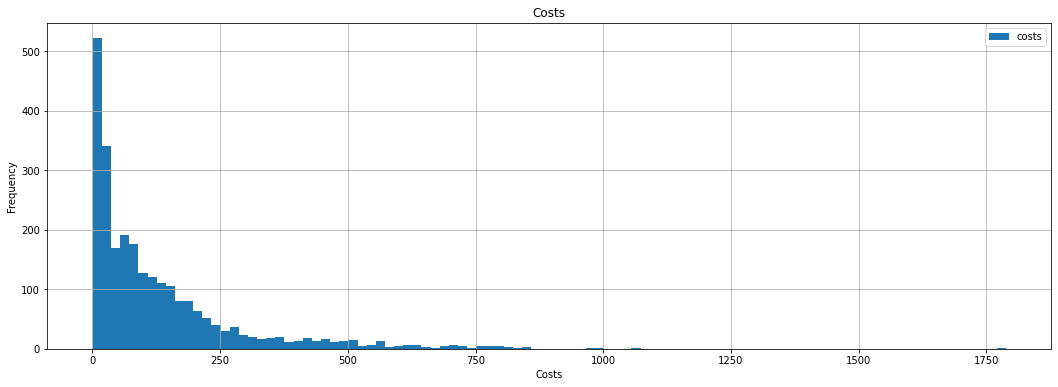

In [32]:
costs.plot(kind='hist', y='costs', bins=100, grid=True, figsize=(18,6), title='Costs')
plt.xlabel('Costs')
plt.ylabel('Frequency')
plt.show()

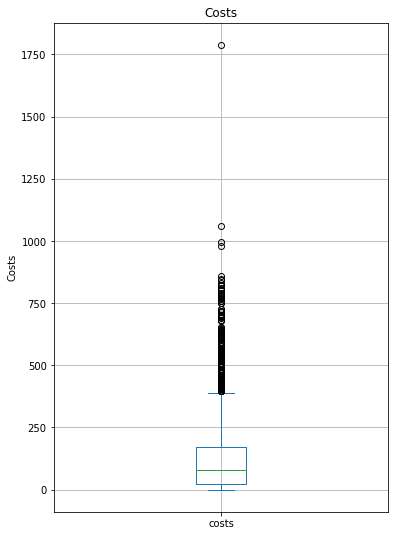

In [33]:
costs.plot(kind='box', y='costs', grid=True, figsize=(6,9), title='Costs')
plt.ylabel('Costs')
plt.show()

The distribution is non-normal. In addition, there are outliers.

### Stage 2. Calculating metrics and building graphs.

#### Product metrics

##### Calculating DAU (Daily Active Users), WAU (Weekly Active Users) и MAU(Monthly Active Users).

Let's calculate the year, month and week, as well as the date of session start date in separate columns.

In [34]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

<ipython-input-34-1caa6c42fac4>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['session_week']  = visits['start_ts'].dt.week


,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


The average DAU over the entire reporting period

In [35]:
dau = visits.groupby('session_date')['uid'].nunique()
dau_total = int(dau.mean())
dau_total

907

The average WAU over the entire reporting period

In [36]:
wau = visits.groupby(['session_year', 'session_week'])['uid'].nunique()
wau_total = int(wau.mean())
wau_total

5716

The average MAU over the entire reporting period


In [37]:
mau = visits.groupby(['session_year', 'session_month'])['uid'].nunique()
mau_total = int(mau.mean())
mau_total

23228

DAU day by day change in the chart

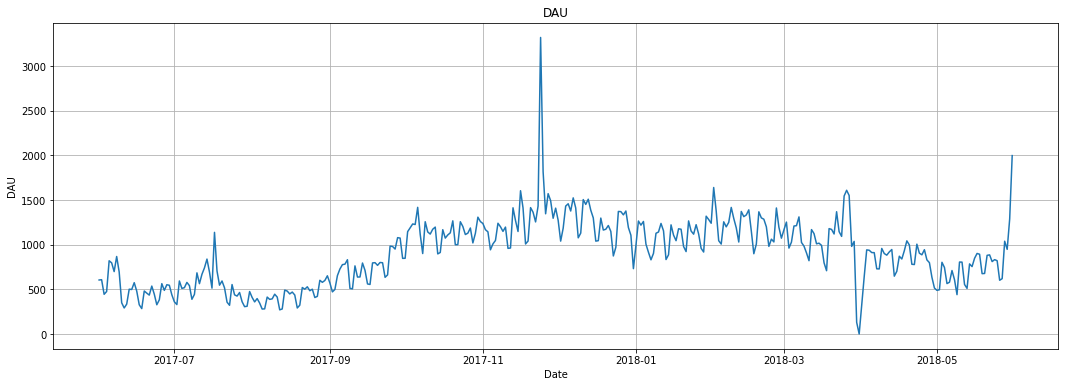

In [38]:
dau.plot(grid=True, figsize=(18,6))
plt.title('DAU')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.show()

Let's look at the outliers from the line graph (above 1700 and around 0)

In [39]:
dau[dau>1700]

session_date
2017-11-24    3319
2017-11-25    1817
2018-05-31    1997
Name: uid, dtype: int64

In [40]:
dau[dau<100]

session_date
2018-03-31    1
Name: uid, dtype: int64

We can see otliers two day in a row in November and at the very end of the period (05/31/2018). Possible reasons:
- Yandex Afisha did something to attract users;
- Аn external reason - an event that attracted users
- Data error. 
The abnormal crash on 03/31/2018 is possible due to an internal technical error or external reasons restricting access to the site.

WAU week by week change

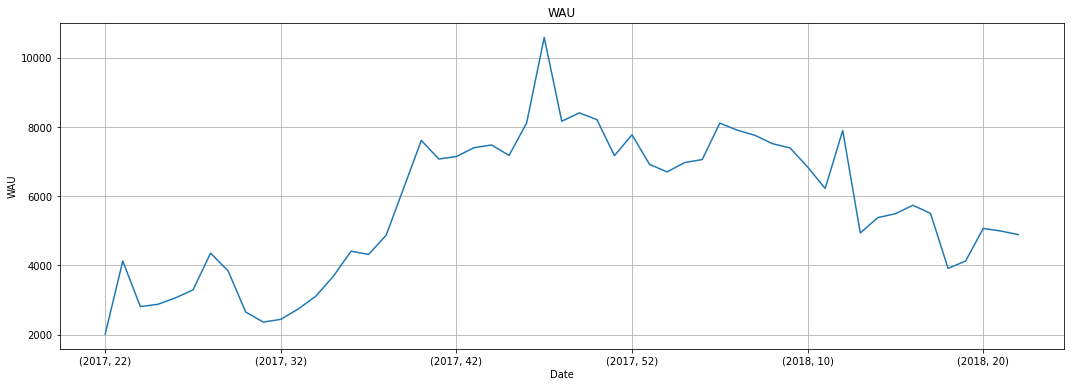

In [41]:
wau.plot(grid=True, figsize=(18,6))
plt.title('WAU')
plt.xlabel('Date')
plt.ylabel('WAU')
plt.show()

Видим рост WAU с середины года до конца года, который сменяется плавным падением в первой половине следующего года. Причины: возможна сезонность (нужны данные за несколько лет чтобы это подтвердить) или изменение активности маркетологов в течение этого периода или внешние факторы: интерес пользователей к контенту сайта. Как выяснить: спросить у маркетологов Яндекс Афиша

We can see the growth of WAU from the middle of the year to the end of the year, after which there is a gradual decrease in the first half of the next year. 
Reasons: 
- seasonality is possible (we need data for several years to confirm this)
- a change in advertising campaigns during this period
- external factor.

MAU change

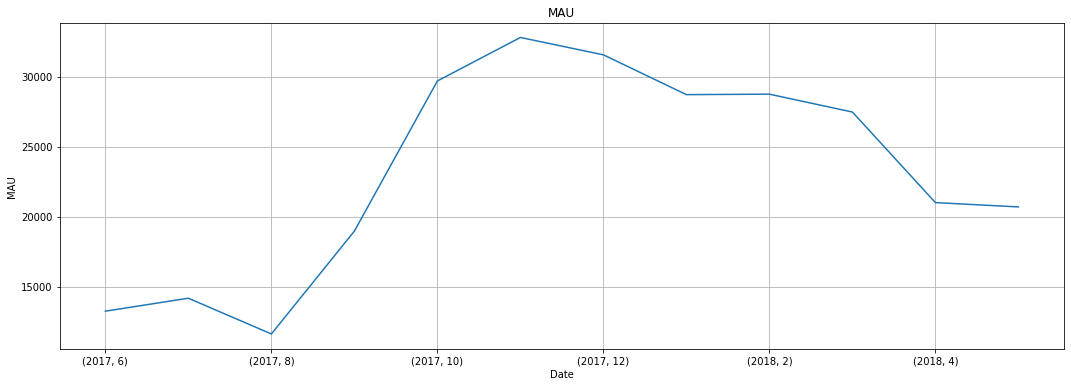

In [42]:
mau.plot(grid=True, figsize=(18,6))
plt.title('MAU')
plt.xlabel('Date')
plt.ylabel('MAU')
plt.show()

В целом тенденции такие же как и динамике WAU: рост с середины года до конца года, который сменяется плавным падением в первой половине следующего года. Возможные причины те же: сезонность (нужны данные за несколько лет чтобы это подтвердить) или изменение активности маркетологов в течение этого периода или внешние факторы: интерес пользователей к контенту сайта (например летом все в отпусках и не интересуются афишей). Как выяснить: спросить у маркетологов Яндекс Афиша
In general, the trends are the same to those of WAU: growth from the middle of the year until the end of the year, which is changed with a gradual decline in the first half of the next year. 
Possible reasons are the same:
- seasonality (we need data for several years to confirm this)
- a change in advertising campaigns 
- external factors.

<b>Results on DAU, WAU, MAU</b><br>
1. There were obvious trends: an increase in the weekly and monthly number of unique users from the beginning of autumn to December 2017. In December 2017, a gradual decline began until the end of the reporting period. Comparing the end with the beginning of the period, we can assume that the number of unique users tends to increase.
2. Possible reasons for this trend: seasonality (data for several years are needed to confirm); marketing activities; external factors (changes in user interest in site content over time)
3. Abnormally high and low DAU values ​​were detected. Possible reasons: Yandex Afisha activity; external event; data error. An abnormal crash is possible due to an internal technical error or external reasons restricting access to the site.

##### How many times per day users visit the site on average. A line graph that reflects changes in the metric over time

Let's group visits by session_date which was calculated in the previous task. Then we will divide the number of visits by the number of unique users to get the average number of visits per user for each day. Let's average this indicator and get the average number of visits for the reporting period.

In [43]:
sessions_per_user_per_day = visits.groupby('session_date').agg({'uid':['count','nunique']})
sessions_per_user_per_day.columns = ['n_sessions','n_users']
sessions_per_user_per_day['sessions_per_user'] = sessions_per_user_per_day['n_sessions'] / sessions_per_user_per_day['n_users']
sessions_per_user_per_day['sessions_per_user'].mean()

1.0821660876897359

An alternative way to calculate average: the sum of visits per day is divided by the sum of unique users per day.

In [44]:
sessions_per_user_per_day['n_sessions'].sum() / sessions_per_user_per_day['n_users'].sum()

1.0874076046340644

Выведем график с изменением метрики по дням

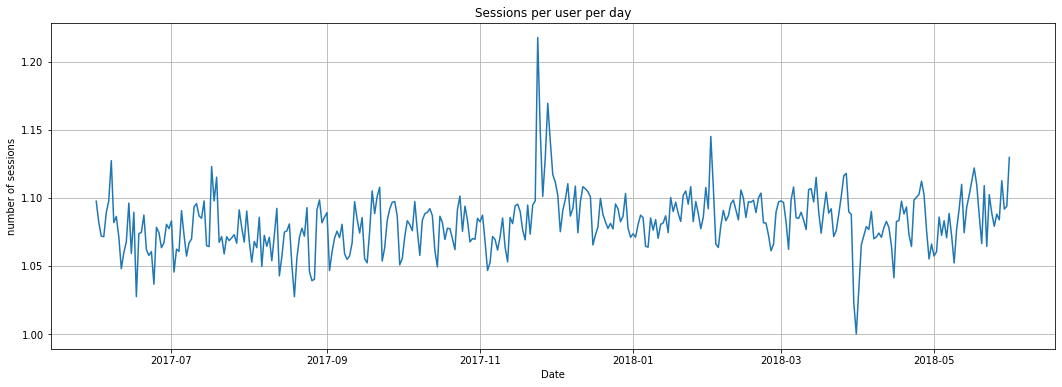

In [45]:
sessions_per_user_per_day['sessions_per_user'].plot(grid=True, figsize=(18,6))
plt.title('Sessions per user per day')
plt.xlabel('Date')
plt.ylabel('number of sessions')
plt.show()

Let's look at the outliers in the graph (above 1.15 and just above 1)

In [46]:
sessions_per_user_per_day[sessions_per_user_per_day['sessions_per_user']>1.15]

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-11-24,4042,3319,1.217837
2017-11-28,1746,1493,1.169457


In [47]:
sessions_per_user_per_day[sessions_per_user_per_day['sessions_per_user']<1.01]

,n_sessions,n_users,sessions_per_user
session_date,,,
2018-03-31,1,1,1.0


<b>Conclusion on the average number of visits per user per day</b><br>
1. Average number of visits: 1.1
2. An abnormally high number of visits per user was detected on November 24 and 28, 2017 (24 also had a high DAU) and an abnormally low activity on March 31, 2018, which coincides with the minimum DAU. 
The reasons can be the same as for DAU outliers:
- Yandex Afisha did something to attract users, including repeat visits;
- external reason: an event happened that somehow led users to the page;
- data error. 
The abnormal crash on 03/31/2018 is possible due to an internal technical error or external reasons restricting access to the site.

##### How long users spend on the site. The duration of a typical user session.

The duration of each session

In [48]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


Let's look at the distribution (we restricted the x scale for better visualization)

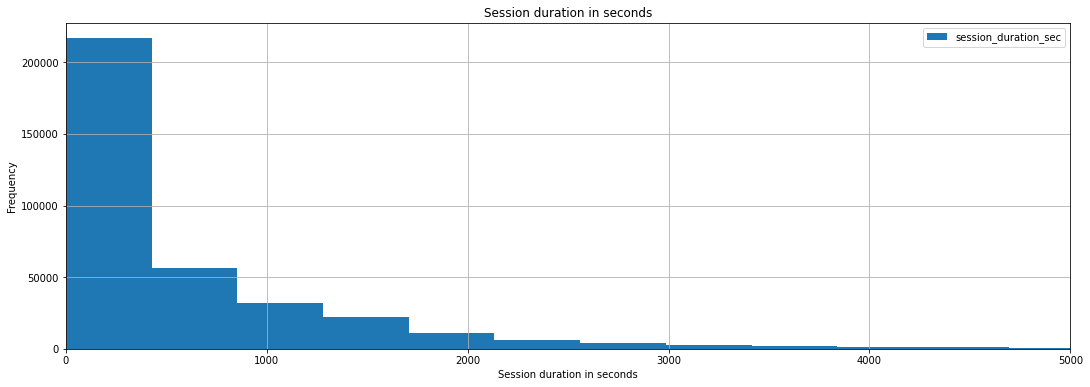

In [49]:
visits.plot(kind='hist', y='session_duration_sec', bins=100, grid=True, figsize=(18,6), title='Session duration in seconds', xlim=(0,5000))
plt.xlabel('Session duration in seconds')
plt.ylabel('Frequency')
plt.show()

In [50]:
visits['session_duration_sec'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

In accordance with the conditions of the task, we will select the mode. Though it is also possible to chose the median.

In [51]:
visits['session_duration_sec'].mode() 

0    60
dtype: int64

<b>Results of the duration of a typical user session</b><br>
Session duration distribution is not normal. the mode is equal to 60 seconds.

##### Retention Rate using cohort analysis. Changes over time on the graph. The average Retention Rate for the second month of the lifetime of the cohorts.

Let's calculate Retention rate by month

Let's find the first purchase date for each user

In [52]:
first_order_date_by_user = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_user.name = 'first_order_date'
first_order_date_by_user.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_date, dtype: datetime64[ns]

We will attach that date back to the orders table

In [53]:
orders = orders.join(first_order_date_by_user, on='uid')
orders.head() 

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


We will add columns with the first month of the order and the month of the order to the orders table 

In [54]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Then we will calculate the lifetime (in months) corresponding to each order (order date - first order date)

In [55]:
orders['cohort_lifetime'] = (orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


Let's create cohorts. We will group by the month of purchase and lifetime.

In [56]:
cohorts = orders.groupby(['first_order_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_order_month,cohort_lifetime,uid
0,2017-06-01,0,2023
1,2017-06-01,1,61
2,2017-06-01,2,50
3,2017-06-01,3,54
4,2017-06-01,4,88


Let's determine the initial number of users in cohorts (users who made an order in lifetime equal to 0)

In [57]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_order_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count.head()

,first_order_month,cohort_users
0,2017-06-01,2023
12,2017-07-01,1923
23,2017-08-01,1370
33,2017-09-01,2581
42,2017-10-01,4340


We will add that number of users back to cohorts.

In [58]:
cohorts = cohorts.merge(initial_users_count,on='first_order_month')
cohorts.head()

,first_order_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,2023,2023
1,2017-06-01,1,61,2023
2,2017-06-01,2,50,2023
3,2017-06-01,3,54,2023
4,2017-06-01,4,88,2023


Let's calculate the retention rate

In [59]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts

,first_order_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,2023,2023,1.000000
1,2017-06-01,1,61,2023,0.030153
2,2017-06-01,2,50,2023,0.024716
3,2017-06-01,3,54,2023,0.026693
4,2017-06-01,4,88,2023,0.043500
...,...,...,...,...,...
73,2018-03-01,1,90,3533,0.025474
74,2018-03-01,2,58,3533,0.016417
75,2018-04-01,0,2276,2276,1.000000
76,2018-04-01,1,69,2276,0.030316


Let's optimize the table view and move lifetime to columns

In [60]:
retention_pivot = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.0,0.030153,0.024716,0.026693,0.043500,0.033119,0.030648,0.023233,0.028670,0.022244,0.022244,0.026199
2017-07-01,1.0,0.027041,0.029641,0.033281,0.025481,0.019761,0.018721,0.020281,0.021841,0.011440,0.013521,NaN
2017-08-01,1.0,0.042336,0.038686,0.032117,0.029197,0.023358,0.021898,0.032117,0.013869,0.022628,NaN,NaN
2017-09-01,1.0,0.050368,0.038745,0.028671,0.020147,0.024797,0.025571,0.014336,0.016660,NaN,NaN,NaN
2017-10-01,1.0,0.047465,0.028341,0.021198,0.021429,0.016590,0.012903,0.015438,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.054398,0.029405,0.025974,0.019848,0.011762,0.015192,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.033311,0.023500,0.022131,0.011408,0.014374,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.033798,0.024607,0.012748,0.013341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.032320,0.015886,0.010682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will visualize and create a heat map

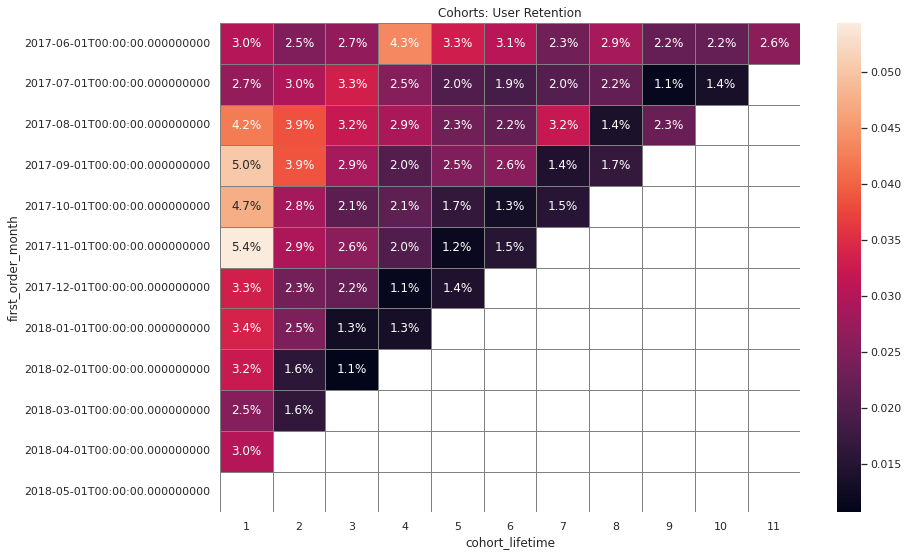

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot.loc[:, retention_pivot.columns != 0], annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Let's find the average Retention Rate for the second month of the lifetime of the cohorts.

In [62]:
cohorts[cohorts['cohort_lifetime']==2]['retention'].mean()

0.026994309207203453

An alternative

In [63]:
cohorts[cohorts['cohort_lifetime']==2]['uid'].sum() / cohorts[cohorts['cohort_lifetime']==2]['cohort_users'].sum()

0.02575340712777529

<b>Retention rate output</b><br>
The retention rate is low (although it needs to be compared with similar products. Maybe this is normal) and generally tends to decrease with the growth of the cohort lifetime (which is basically normal)

#### E-Commerce Metrics

##### How long on average the period between the moment of the first visit to the purchase

Let's find the date of the first visit for each uid

In [64]:
first_visit_date_by_user = visits.groupby('uid')['start_ts'].min()
first_visit_date_by_user.name = 'first_visit_date'
first_visit_date_by_user = first_visit_date_by_user.reset_index()
first_visit_date_by_user.head()

,uid,first_visit_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


The date of the first order for each uid was calculated earlier for the Retention rate

In [65]:
first_order_date_by_user =  first_order_date_by_user.reset_index()
first_order_date_by_user.head()

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Let's combine the dates of the first visit and the first order into one table (by default, merge does an inner join so that only uid with orders will get into the table)

In [66]:
first_visit_first_order = pd.merge(first_order_date_by_user, first_visit_date_by_user)
first_visit_first_order.head()

,uid,first_order_date,first_visit_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


We will add a column with date difference and calculate the average

In [67]:
first_visit_first_order['time_to_order'] = first_visit_first_order['first_order_date'] - first_visit_first_order['first_visit_date']
first_visit_first_order.head()

,uid,first_order_date,first_visit_date,time_to_order
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


In [68]:
first_visit_first_order['time_to_order'].mean()

Timedelta('16 days 21:40:50.532281912')

Let's convert to days and look at the distribution

In [69]:
first_visit_first_order['days_to_order'] = first_visit_first_order['time_to_order'] / np.timedelta64(1, 'D')
first_visit_first_order['days_to_order'].describe()

count    36522.000000
mean        16.903363
std         47.073322
min          0.000000
25%          0.002778
50%          0.011111
75%          2.012153
max        363.294444
Name: days_to_order, dtype: float64

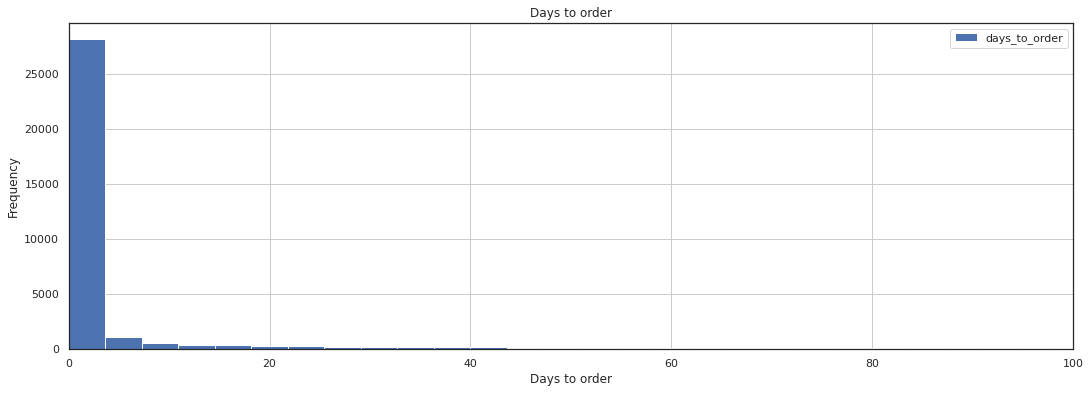

In [70]:
first_visit_first_order.plot(kind='hist', y='days_to_order', bins=100, grid=True, figsize=(18,6), title='Days to order', xlim=(0,100))
plt.xlabel('Days to order')
plt.ylabel('Frequency')
plt.show()

<b>Conclusion on the average time between the first visit to the site and the first purchase</b><br>
The average time is 16 days, however the distribution is not normal. At least 50% of orders (median) are made on the day of the first visit, which is strange given the specifics of the site. The second question: data on orders have the same period as on visits, i.e. orders made after the reporting period by users whose first visit was in the reporting period were not included - i.e. the indicator is underestimated.

##### Using cohort analysis, we calculate the average number of purchases per customer for 6 months.

Let's create cohorts and write down the number of unique users and the number of orders in them

In [71]:
cohorts_n_orders = orders.groupby(['first_order_month','cohort_lifetime']).agg({'uid':['nunique','count']}).reset_index()
cohorts_n_orders.columns = ['first_order_month','cohort_lifetime', 'n_users', 'n_orders']
cohorts_n_orders.head()

,first_order_month,cohort_lifetime,n_users,n_orders
0,2017-06-01,0,2023,2354
1,2017-06-01,1,61,177
2,2017-06-01,2,50,174
3,2017-06-01,3,54,226
4,2017-06-01,4,88,292


We do not need cohorts with a lifetime of 5 or less. We exclude first order dates that are in 2018.

In [72]:
cohorts_n_orders = cohorts_n_orders[(cohorts_n_orders['first_order_month']<'2018-01-01')&(cohorts_n_orders['cohort_lifetime']<6)]
cohorts_n_orders.head()

,first_order_month,cohort_lifetime,n_users,n_orders
0,2017-06-01,0,2023,2354
1,2017-06-01,1,61,177
2,2017-06-01,2,50,174
3,2017-06-01,3,54,226
4,2017-06-01,4,88,292


The average number of purchases per customer over 6 months for customers who have had 6 months since their first purchase.

In [73]:
cohorts_n_orders['n_orders'].sum() / cohorts_n_orders['n_users'].sum()

1.2404670912951168

<b>Conclusion on the average number of purchases per customer for 6 months</b><br>
Average 1.24

##### Let's calculate AOV (Average order value), using grouping by the time of the purchase.

Let's calcultate Average Order Value for the entire period

In [74]:
aov = orders['revenue'].sum() / orders['uid'].count()
aov

4.9996782639742925

Let's build a chart by month

In [75]:
aov_per_month = orders.groupby(['order_month']).agg({'revenue':'sum','uid':'count'})
aov_per_month['aov_per_month'] = aov_per_month['revenue'] / aov_per_month['uid']
aov_per_month

,revenue,uid,aov_per_month
order_month,,,
2017-06-01,9557.49,2354,4.060106
2017-07-01,12539.47,2363,5.306589
2017-08-01,8758.78,1807,4.847139
2017-09-01,18345.51,3387,5.416448
2017-10-01,27987.70,5679,4.928280
2017-11-01,27069.93,5659,4.783518
2017-12-01,36388.60,6218,5.852139
2018-01-01,19417.13,4721,4.112927
2018-02-01,25560.54,5281,4.840095


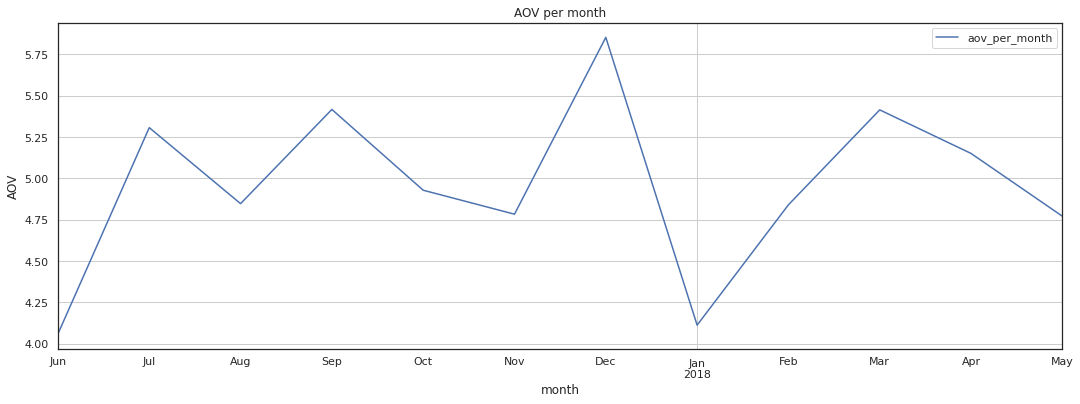

In [76]:
aov_per_month.plot(y='aov_per_month', grid=True, figsize=(18,6))
plt.title('AOV per month')
plt.xlabel('month')
plt.ylabel('AOV')
plt.show()

<b>Conclusion on the average check</b><br>
The average check for the entire period is 5. When assessed by months, fluctuations are visible with minimum values in June 2017 and January 2018. The maximum average check was in December 2017. Perhaps there were discounts in periods with a minimum value, so we will additionally look at the number of purchases in these months.

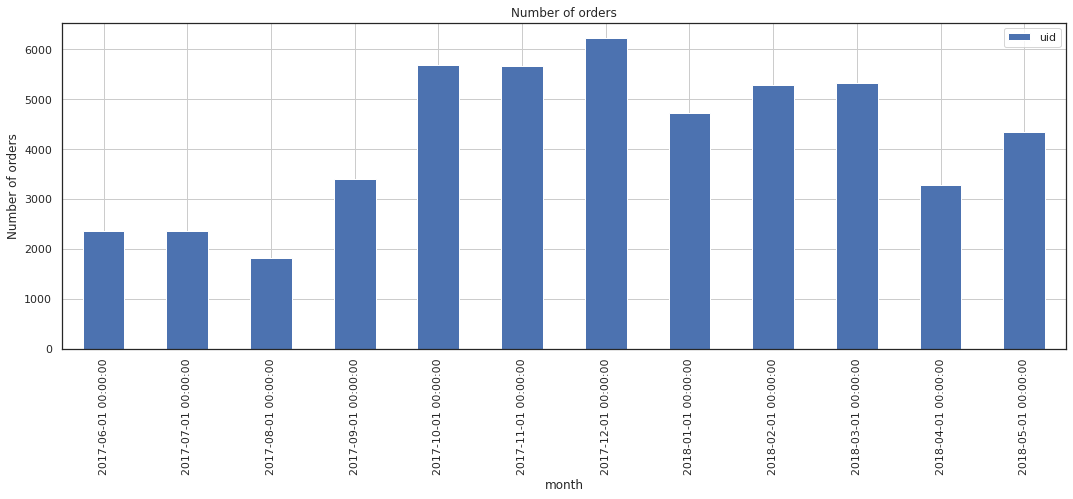

In [77]:
aov_per_month.plot(kind='bar',y='uid', grid=True, figsize=(18,6))
plt.title('Number of orders')
plt.xlabel('month')
plt.ylabel('Number of orders')
plt.show()

If there were discounts, they did not affect the number of orders.

##### Finding out how LTV per customer changes by cohort. Let's calculate the average LTV by cohorts for 6 months; we include in the calculation cohorts that have “lived” for at least 6 months.

Let's form cohorts and exclude cohorts with lifetime less than 5 by the date of the first order

In [78]:
cohorts_for_ltv = (
    orders[orders['first_order_month'] < '2018-01-01'].groupby(['first_order_month', 'cohort_lifetime'])
    .agg({'revenue': 'sum'})
    .reset_index()
    )
cohorts_for_ltv.head()

,first_order_month,cohort_lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58


Add the number of users in each cohort (number of users with lifetime 0, calculated earlier in the retention rate)

In [79]:
cohorts_for_ltv = cohorts_for_ltv.merge(initial_users_count,on='first_order_month')
cohorts_for_ltv.head()

,first_order_month,cohort_lifetime,revenue,cohort_users
0,2017-06-01,0,9557.49,2023
1,2017-06-01,1,981.82,2023
2,2017-06-01,2,885.34,2023
3,2017-06-01,3,1931.30,2023
4,2017-06-01,4,2068.58,2023


Let's determine the gross profit by multiplying the revenue by the margin, which, according to the condition, is 100%

In [80]:
margin_rate = 1

cohorts_for_ltv['gp'] = cohorts_for_ltv['revenue'] * margin_rate
cohorts_for_ltv.head()

,first_order_month,cohort_lifetime,revenue,cohort_users,gp
0,2017-06-01,0,9557.49,2023,9557.49
1,2017-06-01,1,981.82,2023,981.82
2,2017-06-01,2,885.34,2023,885.34
3,2017-06-01,3,1931.30,2023,1931.30
4,2017-06-01,4,2068.58,2023,2068.58


Найдём LTV и представим в виде сводной  и накопительным итогом
Let's find LTV and present it as a summary and cumulative total

In [81]:
cohorts_for_ltv['ltv'] = cohorts_for_ltv['gp'] / cohorts_for_ltv['cohort_users']
cohorts_for_ltv.head()

,first_order_month,cohort_lifetime,revenue,cohort_users,gp,ltv
0,2017-06-01,0,9557.49,2023,9557.49,4.724414
1,2017-06-01,1,981.82,2023,981.82,0.485329
2,2017-06-01,2,885.34,2023,885.34,0.437637
3,2017-06-01,3,1931.30,2023,1931.30,0.954671
4,2017-06-01,4,2068.58,2023,2068.58,1.022531


In [82]:
output = cohorts_for_ltv.pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean'
).round(2)
output.cumsum(axis=1)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN


We will also display without a cumulative total to understand the increase in LTV by months

In [83]:
output

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN


Let's calculate the average LTV by cohorts for 6 months

In [84]:
ltv_6m = output.cumsum(axis=1)[5]
ltv_6m

first_order_month
2017-06-01     8.36
2017-07-01     7.67
2017-08-01     7.37
2017-09-01    12.31
2017-10-01     6.16
2017-11-01     6.27
2017-12-01     7.65
Name: 5, dtype: float64

In [85]:
ltv_6m.mean()

7.970000000000001

Visualizing LTV by cohorts

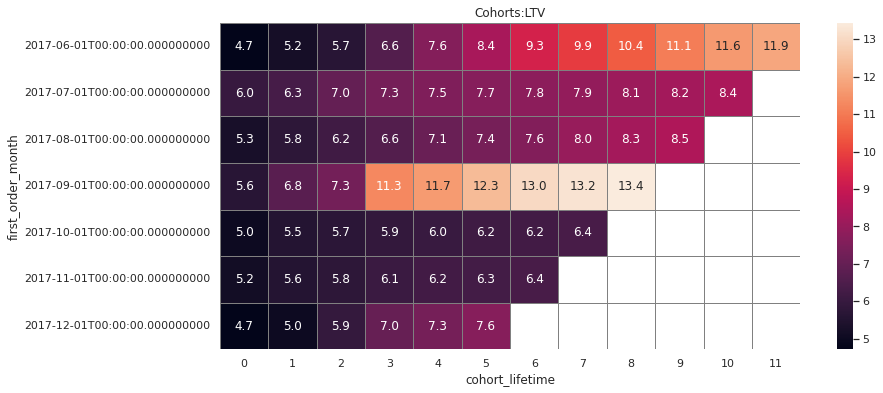

In [86]:
sns.set(style='white')
plt.figure(figsize=(13, 6))
plt.title('Cohorts:LTV')
sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

<b>Conclusion on LTV</b><br>
The average LTV for 6 months for cohorts with a lifetime of at least 5 months 7.97. When evaluating by months, it is clear that the client creates the main value in the first month, and in subsequent months, the increase in LTV is small. At the same time, different cohorts differ slightly in terms of LTV. The cohort that started in September 2017 stands out: the maximum LTV for 6 months due to the large increase in December 2017.

#### Marketing Metrics

##### Calculating the total cost of marketing. How spending is distributed by source. Visualizing changes in metrics over time

Amount of marketing expenses

In [87]:
costs['costs'].sum()

329131.62

Distribution by source

In [88]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Creating columns for weeks, months, years

In [89]:
costs['cost_year']  = costs['dt'].dt.year
costs['cost_month'] = costs['dt'].dt.month
costs['cost_week']  = costs['dt'].dt.week
costs.head()

<ipython-input-89-3cd9251b5d3e>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  costs['cost_week']  = costs['dt'].dt.week


,source_id,dt,costs,cost_year,cost_month,cost_week
0,1,2017-06-01,75.20,2017,6,22
1,1,2017-06-02,62.25,2017,6,22
2,1,2017-06-03,36.53,2017,6,22
3,1,2017-06-04,55.00,2017,6,22
4,1,2017-06-05,57.08,2017,6,23


Graph

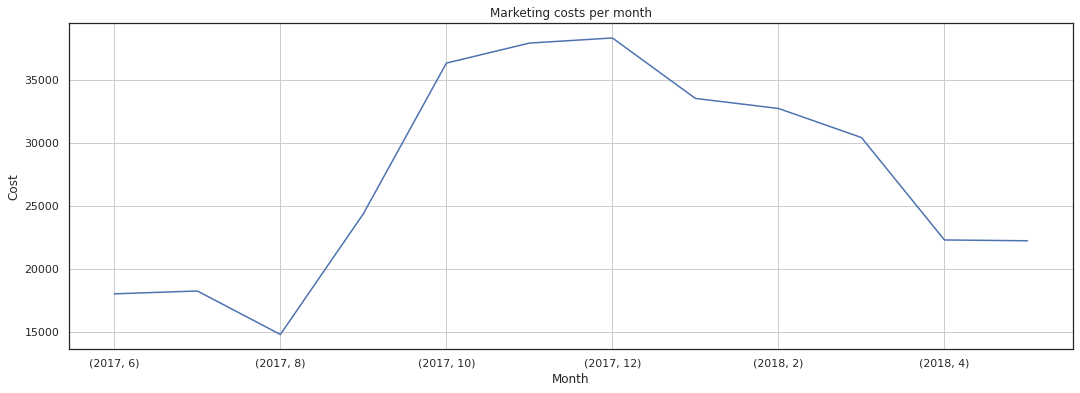

In [90]:
costs.groupby(['cost_year', 'cost_month'])['costs'].sum().plot(grid=True, figsize=(18,6))
plt.title('Marketing costs per month')
plt.xlabel('Month')
plt.ylabel('Cost')
plt.show()

The chart resembles the MAU chart. Let's look at them in one graph

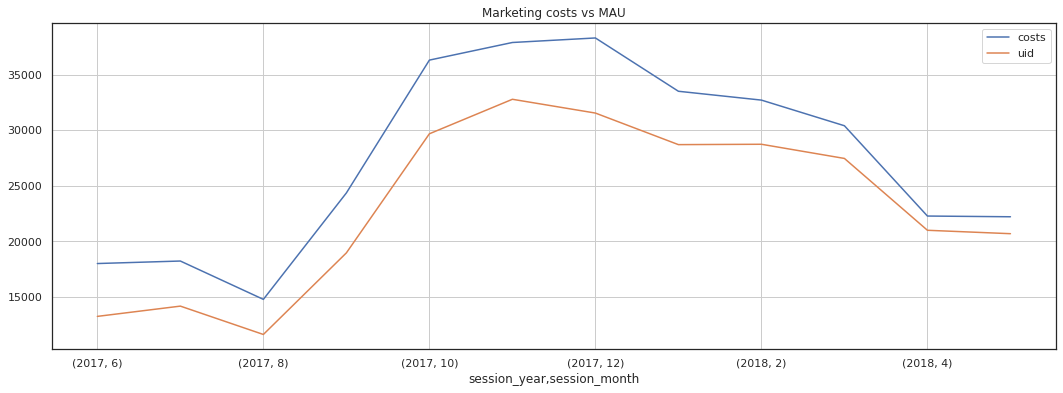

In [91]:
costs.groupby(['cost_year', 'cost_month'])['costs'].sum().plot(grid=True, figsize=(18,6), legend=True)
mau.plot(grid=True, figsize=(18,6), legend=True)
plt.title('Marketing costs vs MAU')
plt.show()

Chart by traffic source

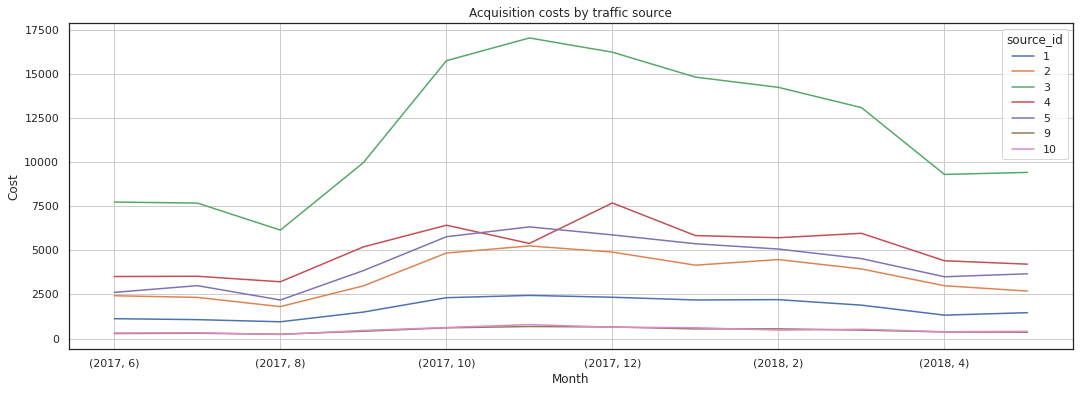

In [92]:
costs.pivot_table(index=['cost_year', 'cost_month'], columns='source_id',values="costs",aggfunc='sum').plot(grid=True, figsize=(18, 6))
plt.title('Acquisition costs by traffic source')
plt.xlabel('Month')
plt.ylabel('Cost')
plt.show()

In [93]:
costs.pivot_table(index=['cost_year', 'cost_month'], columns='source_id',values="costs",aggfunc='sum')

source_id                  1        2         3        4        5       9   \
cost_year cost_month                                                         
2017      6           1125.61  2427.38   7731.65  3514.80  2616.12  285.22   
          7           1072.88  2333.11   7674.37  3529.73  2998.14  302.54   
          8            951.81  1811.05   6143.54  3217.36  2185.28  248.93   
          9           1502.01  2985.66   9963.55  5192.26  3849.14  415.62   
          10          2315.75  4845.00  15737.24  6420.84  5767.40  609.41   
          11          2445.16  5247.68  17025.34  5388.82  6325.34  683.18   
          12          2341.20  4897.80  16219.52  7680.47  5872.52  657.98   
2018      1           2186.18  4157.74  14808.78  5832.79  5371.52  547.16   
          2           2204.48  4474.34  14228.56  5711.96  5071.31  551.50   
          3           1893.09  3943.14  13080.85  5961.87  4529.62  480.29   
          4           1327.49  2993.70   9296.81  4408.49  3501.15  373.49   
          5           1467.61  2689.44   9411.42  4214.21  3669.56  362.17   

source_id                 10  
cost_year cost_month          
2017      6           314.22  
          7           329.82  
          8           232.57  
          9           460.67  
          10          627.24  
          11          792.36  
          12          645.86  
2018      1           614.35  
          2           480.88  
          3           526.41  
          4           388.25  
          5           409.86

<b>Conclusion on marketing expenses</b><br>
In total, 329 thousand were spent over the period. Monthly spending grew in the second half of 2017 and decreased in the first half of 2018. This probably had a direct impact on the MAU - the graphs are almost the same. The breakdown by traffic sources shows that the most spent on source 3 and it is its change that determines the overall dynamics of expenses.

##### Let's calculate the average CAC (Customer Acquisition Cost) per buyer for the entire project and for each traffic source. We reflect changes in metrics on charts;

Average CAC per customer for the entire period

In [94]:
cac = costs['costs'].sum() / orders['uid'].nunique()
cac.round(2)

9.01

Average CAC per buyer for the entire period for each traffic source

Grouping costs by traffic source

In [95]:
source_cost = costs.groupby('source_id')['costs'].sum().reset_index()
source_cost

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


There are no sources in orders, but there are in visits. In visits we will define the first traffic source for each user

In [96]:
uid_source = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid')['source_id'].first().reset_index()
uid_source

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


Merging with orders (let's make a left join and check if all uids from orders have a traffic source specified)

In [97]:
orders_for_cac = pd.merge(orders,uid_source, on='uid', how='left')
orders_for_cac.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


In [98]:
orders_for_cac[orders_for_cac['source_id'].isnull()]

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,cohort_lifetime,source_id


Grouping by source_id

In [99]:
source_uid = orders_for_cac.groupby('source_id')['uid'].nunique().reset_index()
source_uid

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1329


Let's combine both tables by source_id and determine the CAC for each traffic source

In [100]:
uid_source_cac = pd.merge(source_uid,source_cost, on='source_id')
uid_source_cac['cac'] = (uid_source_cac['costs'] / uid_source_cac['uid']).round(2)
uid_source_cac

,source_id,uid,costs,cac
0,1,2899,20833.27,7.19
1,2,3506,42806.04,12.21
2,3,10473,141321.63,13.49
3,4,10295,61073.60,5.93
4,5,6931,51757.10,7.47
5,9,1088,5517.49,5.07
6,10,1329,5822.49,4.38


Let's determine changes by month

Finding the total advertising costs for the pair source - month

In [101]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,cost_year,cost_month,cost_week,month
0,1,2017-06-01,75.20,2017,6,22,2017-06-01
1,1,2017-06-02,62.25,2017,6,22,2017-06-01
2,1,2017-06-03,36.53,2017,6,22,2017-06-01
3,1,2017-06-04,55.00,2017,6,22,2017-06-01
4,1,2017-06-05,57.08,2017,6,23,2017-06-01


In [102]:
source_cost_per_month = costs.groupby(['source_id','month'])['costs'].sum().reset_index()
source_cost_per_month.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Finding the total number of buyers for pairs first_source-first_month

In [103]:
source_month_uid = orders_for_cac[orders_for_cac['cohort_lifetime']==0].groupby(['source_id','order_month'])['uid'].nunique().reset_index()
source_month_uid.head()

,source_id,order_month,uid
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340


Combining two tables and dividing costs by buyers.

In [104]:
cac_per_month = pd.merge(source_month_uid,source_cost_per_month, left_on=['source_id','order_month'], right_on=['source_id','month'])
cac_per_month['cac'] = (cac_per_month['costs'] / cac_per_month['uid']).round(2)
cac_per_month.head()

,source_id,order_month,uid,month,costs,cac
0,1,2017-06-01,190,2017-06-01,1125.61,5.92
1,1,2017-07-01,160,2017-07-01,1072.88,6.71
2,1,2017-08-01,113,2017-08-01,951.81,8.42
3,1,2017-09-01,227,2017-09-01,1502.01,6.62
4,1,2017-10-01,340,2017-10-01,2315.75,6.81


Let's make a pivot and visualize

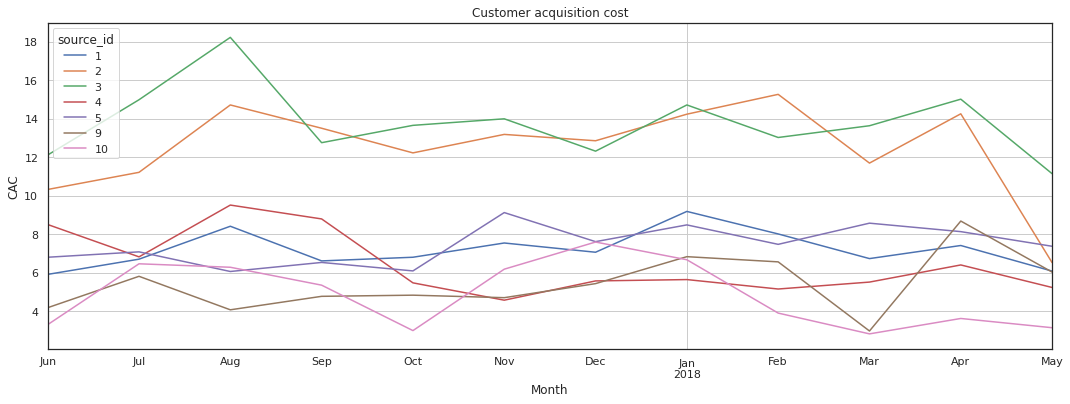

In [105]:
cac_per_month.pivot_table(index='month', columns='source_id', values='cac', aggfunc='sum').plot(grid=True, figsize=(18, 6))
plt.title('Customer acquisition cost')
plt.xlabel('Month')
plt.ylabel('CAC')
plt.show()

<b>Conclusion on CAC</b><br>
The average customer acquisition cost for the entire period is 9.01. While breaking down by traffic source it is from 4.4 to 13.5. There are two sources 2 and 3 with the highest CAC.

##### Calculating ROMI by cohorts in the context of sources. Let's compare the payback for the same periods of life of the cohorts.

Determining the first traffic source for each uid

In [106]:
users = visits.sort_values(by = ['uid','start_ts']).groupby('uid').agg({'source_id':'first'}) 
users.head()

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


Selecting the sources for which there were expenses

In [107]:
sources = costs['source_id'].unique()
sources

array([ 1,  2,  3,  4,  5,  9, 10])

We display ROMI for each source separately, for this we make a cycle

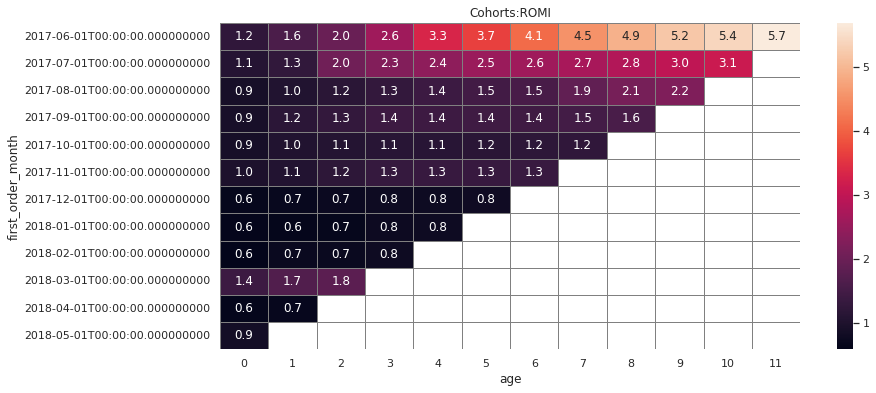

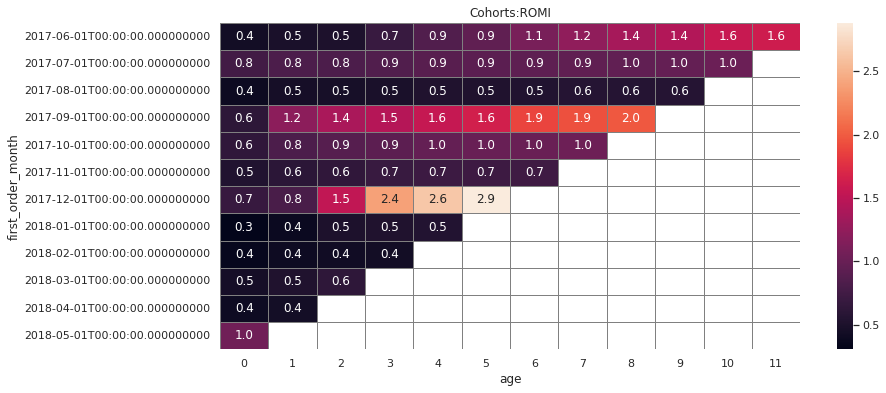

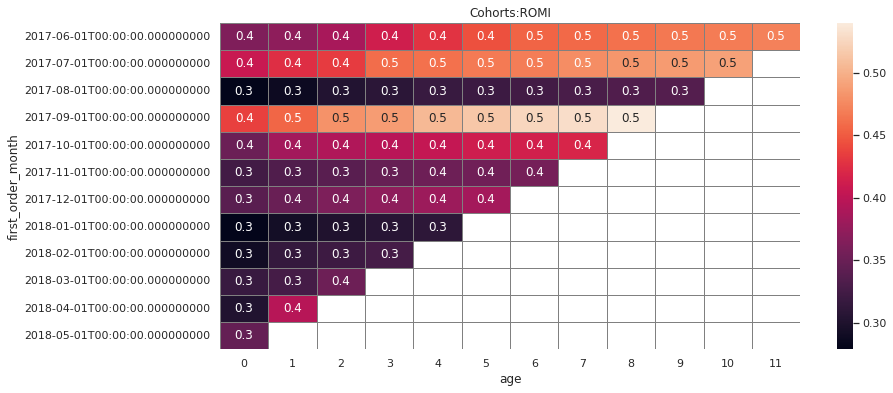

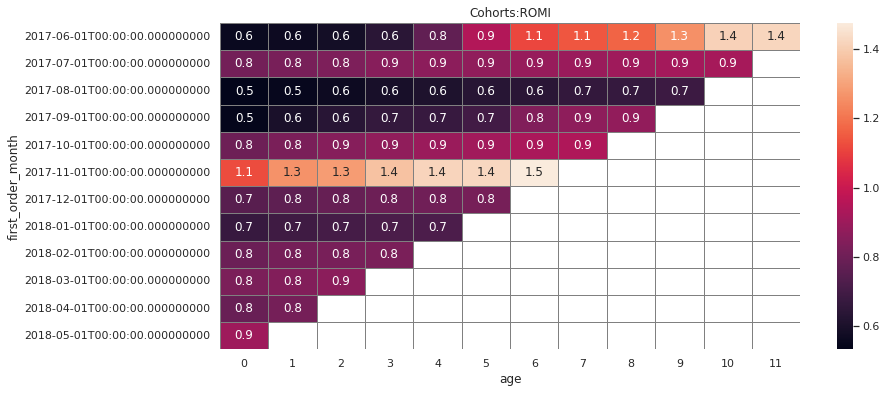

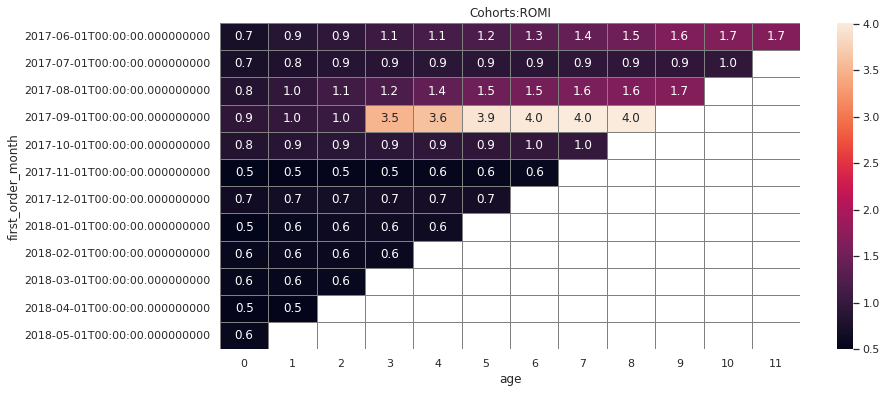

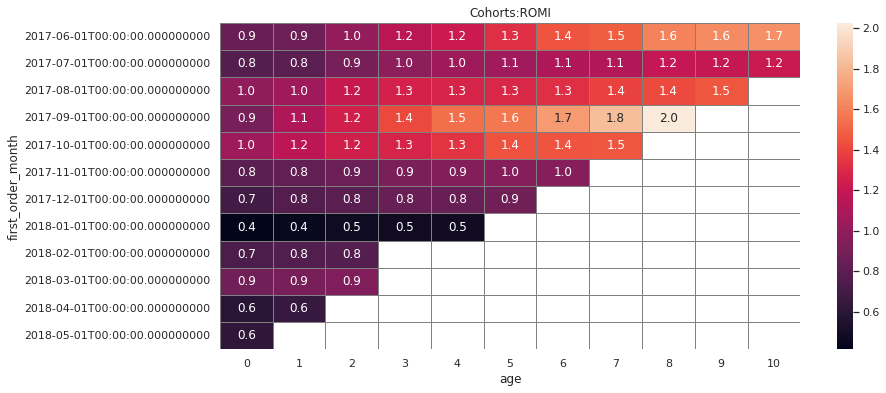

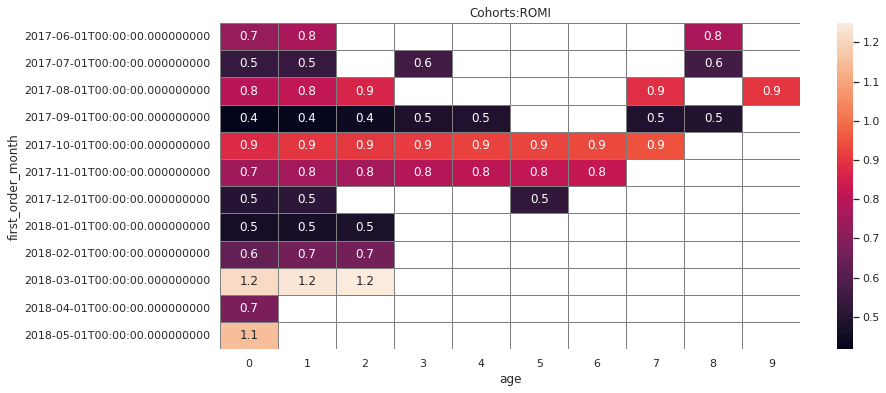

In [108]:
for source in sources:

    source_users = users.query('source_id == @source').index.values #select uid with desired source_id
    source_orders = orders.query('uid in @source_users') #select orders with the desired uid

    # Determining the size of the cohort (number of unique uids in the first month of life)
    cohort_sizes_for_romi = source_orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
    cohort_sizes_for_romi.columns = ['first_order_month','n_buyers']

    # Forming cohorts (month of the first order, month of orders, revenue )
    cohorts_for_romi = source_orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()

    # Adding cohort size (number of customers in the first month)
    report = pd.merge(cohort_sizes_for_romi, cohorts_for_romi, on='first_order_month')

    # Calculating LTV
    margin_rate = 1 # by condition

    report['gp'] = report['revenue'] * margin_rate #gross profit
    report['age'] = ((report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int') #lifetime
    report['ltv'] = report['gp'] / report['n_buyers']

    output_romi = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean') # converting into pivot
    output_romi = output_romi.cumsum(axis=1).fillna(0) # calculating cumulative total LTV

    # Calculating costs by month
    source_costs = costs.query('source_id ==@source') # Selecting costs for desired source_id
    month_costs = source_costs.groupby('month')['costs'].sum().reset_index()

    #Calculating CAC and ROMI
    report_romi = pd.merge(report, month_costs, left_on='first_order_month', right_on='month') # addind costs to cohorts
    report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers'] #CAC
    report_romi['romi'] = report_romi['ltv'] / report_romi['cac'] #ROMI
    
    output_romi_pivot = report_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean') #converting into pivot
    output_romi_pivot = output_romi_pivot.cumsum(axis=1)
    #display(output_romi_pivot)

    #creating heatmap
    
    sns.set(style='white')
    plt.figure(figsize=(13, 6))
    plt.title('Cohorts:ROMI')
    sns.heatmap(output_romi_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

<b>Conclusion on ROMI</b><br>
Let's compare by ROMI for month 6 (age 5 in the charts).
- In the first source (source_id = 1) in the oldest cohort (June 2017), ROMI is high (3.7). But the indicator steadily decreases with the increase in first_order_month and in the December cohort it becomes less than 1 (i.e. we are already working at a loss)
- In the second source (source_id = 2) ROMI for all cohorts is below 1 except those that started in September and December 2017
- Third source (source_id = 3): ROMI in all cohorts below 1
- In source 4, ROMI is also low except for the cohort that started in November 2017
- Source 5: interesting September 2017 cohort with ROMI 3.9 (increase since December 2017) other cohorts mostly below 1
- Source 9: ROMI on average is above 1 except for the last cohort from January 2018
- Source 10: ROMI below 1 and fragmentary data - few sales(?)

### Stage 3. Conclusion and recommendations

#### Traffic sources that need attention

Based on the results of the analysis of visits to the Yandex.Afisha website from June 2017 to May 2018, orders for this period and advertising costs for the same period, the conclusions are as follows:
1. Urgently pay attention to three sources of traffic with a large flow of buyers and problems with profitability:
    - Traffic source 3: unprofitable channel with ROMI below 1, while spending on it is maximum. Marketing activity leads to a significant increase in traffic, moreover, the amount of expenses during the reporting period correlates with MAU. However, high attendance is not effectively converted into orders. The number of buyers is high, but due to high costs, CAC is also the maximum in this source. Recommendation: do not spend money on attraction from this source.
    - Traffic source 4: in general, also a loss-making sales channel. Acquisition costs are high, but due to the large number of buyers CAC is low. At the same time, one cohort that started in November 2017 has a ROMI above 1. Recommendation: analyze the profitable cohort and more accurately target marketing activity for this source. The second option is not to spend money on attraction from this source.
    - Traffic source 5: ROMI below 1 in half of the cohorts, while there is an interesting cohort from September 2017 with a ROMI of 3.9. Recommendation: analyze the profitable cohort and target marketing activity more precisely to this source.
2. Traffic sources for which it is also desirable to adjust marketing:
    - Source 9: Generally profitable, ROMI average above 1 except for the last cohort from January 2018. Costs are low, CAC is low. The number of buyers is also low. Recommendation: it makes sense to increase activity in this source
    - Source 1: High ROMI in cohorts started in June-July 2017. Acquisition costs are low relative to other sources. But ROMI steadily declined in subsequent cohorts and reached below 1 in the December 2017 cohort. Since CAC did not grow much, the reason was the decrease in LTV. Recommendations: analyze what has changed in clients in this source and possibly stop spending money on it.
    - Source 2: two cohorts (started in September and December 2017) show a good ROMI, the rest is bad. Also, the cost of acquisition (CAC) in this channel is high. Recommendations: find out who we have attracted in these profitable cohorts and aim at these target groups. Reduce costs through targeting.
    - Source 10: ROMI below 1 and fragmented data - few sales(?). Recommendations: do not waste resources on this source

#### Conclusions after calculating the metrics of each type: marketing, product and e-commerce metrics.

1. Marketing
    - Total expenditures for the whole period 329 thousand. Monthly spending grew in the second half of 2017 and decreased in the first half of 2018. When broken down by traffic sources, it is clear that source 3 was spent the most, and it is its change that determines the overall dynamics of expenses. The change in the level of spending was reflected in the MAU, the graphs are almost the same.
    - The average cost of attracting a client for the entire period is 9.01. The breakdown by traffic source is from 4.4 to 13.5. There are two sources 2 and 3 with the highest CAC.
    - By traffic source: most spent on source 3, not very efficient. Sources 4 and 5, second in terms of expenditure, also require correction. Minimum spending on sources 9 and 10. Source 9 is profitable, spending on it can be increased.
<br>
2. Product:
    - There are a few clear trends: an increase in the weekly and monthly number of unique users from the beginning of autumn to December 2017. In December 2017, a gradual decline began until the end of the reporting period. In general, comparing the end with the beginning of the period, we can assume that the number of unique users tends to increase. Reasons: marketing activity, although seasonality or external factors cannot be ruled out.
    - Abnormally high and low DAU values ​​have been identified. Possible reasons: Yandex Afisha activity; external event; data error. An abnormal crash is possible due to an internal technical error or external reasons restricting access to the site.
    - Average number of visits: 1.1. An abnormally high number of visits per user was detected on November 24 and 28, 2017 (24 also had a high DAU) and abnormally low activity on 03/31/2018, which coincides with the minimum DAU. The reasons are obviously the same as for DAU outliers: Yandex Afisha did something to attract users, including repeat visits; external reason: an event happened that somehow led users to the page; data error. The abnormal crash on 03/31/2018 is possible due to an internal technical error or external reasons restricting access to the site.
    - Typical session duration (mode) is extremely short: 60 seconds.
    - Retention rate is low (although it needs to be compared with similar products - maybe it is normal) and generally tends to decrease with increasing cohort lifetime (which is basically normal)
<br>
3. Ecommerce Metrics
    - The average time between the first visit to the site and the first purchase is 16 days, however the distribution is not normal and at least 50% of orders (median) are made on the day of the first visit.
    - Average number of purchases per customer in 6 months: 1.24
    - The average check for the entire period is 5. When assessed by months, fluctuations are visible with minimum values ​​in June 2017 and January 2018. The maximum average check was in December 2017.
    - Average LTV for 6 months for cohorts with a lifetime of at least 5 months 7.97. When evaluating by months, it is clear that the client creates the main value in the first month, and in subsequent months, the increase in LTV is small. At the same time, different cohorts differ slightly in terms of LTV. The cohort that started in September 2017 stands out: the maximum LTV for 6 months due to the large increase in December 2017.

####  Results of the cohort analysis. Promising client cohorts for the company.

Profitable cohorts in which you need to keep or increase retention

  - traffic_source 4, start date: November 2017
  - source 5, September 2017
  - source 9, all dates
  - source 1, June-July 2017
  - source 2, September 2017 and December 2017